# Deep Learning & Art: Neural Style Transfer

In this assignment, you will learn about Neural Style Transfer. This algorithm was created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

**In this assignment, you will:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. In Neural Style Transfer, you'll optimize a cost function to get pixel values!

Acknowledgement: This is insipred by https://www.coursera.org/specializations/deep-learning#courses

In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import torch
import numpy as np
import pprint
%matplotlib inline

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. It merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the [original NST paper](https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

In [2]:
import torchvision.models as models
model = models.vgg19(pretrained=True)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [3]:
"Our model has %dM parameters" % (np.sum([w.numel() for w in model.parameters()])/10**6)

'Our model has 143M parameters'

## Getting Content and Style Images

In [4]:
# Download the contenct image (Lehigh Image) (change the content images!)
! wget https://coral.ise.lehigh.edu/~mopta2019/images/IMG_4622.JPG

--2020-03-05 18:39:06--  https://coral.ise.lehigh.edu/~mopta2019/images/IMG_4622.JPG
Resolving coral.ise.lehigh.edu (coral.ise.lehigh.edu)... 128.180.35.203
Connecting to coral.ise.lehigh.edu (coral.ise.lehigh.edu)|128.180.35.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487877 (476K) [image/jpeg]
Saving to: ‘IMG_4622.JPG’

IMG_4622.JPG        100%[===================>] 476.44K  1.04MB/s    in 0.4s    

2020-03-05 18:39:07 (1.04 MB/s) - ‘IMG_4622.JPG’ saved [487877/487877]



(600, 800, 3)


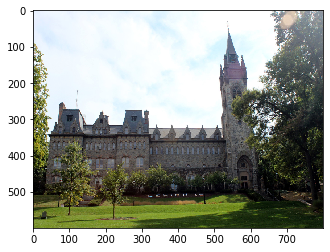

In [5]:
import cv2
img = cv2.imread('./IMG_4622.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (800,600))
plt.imshow(img)
print (img.shape)
contentImage = torch.tensor(img/255.0).float().cuda()

In [6]:
# download style image (change the style images!)
! wget https://images-na.ssl-images-amazon.com/images/I/71KhW7VgXNL._SX466_.jpg

--2020-03-05 18:39:27--  https://images-na.ssl-images-amazon.com/images/I/71KhW7VgXNL._SX466_.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 151.101.1.16, 151.101.65.16, 151.101.129.16, ...
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|151.101.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55708 (54K) [image/jpeg]
Saving to: ‘71KhW7VgXNL._SX466_.jpg’

71KhW7VgXNL._SX466_ 100%[===================>]  54.40K  --.-KB/s    in 0.008s  

2020-03-05 18:39:27 (6.68 MB/s) - ‘71KhW7VgXNL._SX466_.jpg’ saved [55708/55708]



(600, 800, 3)


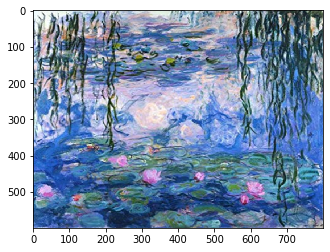

In [7]:
import cv2
img = cv2.imread('./71KhW7VgXNL._SX466_.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (800,600))
plt.imshow(img)
print (img.shape)
styleImage = torch.tensor(img/255.0).float().cuda()

## Obtaining various layers from the model

In [10]:
# We care about the first part of the model (model.features)
layers = []
for idx, m in enumerate(model.features.modules()):
    if idx > 0:
      print(idx, '->', m)
      layers.append([m,isinstance(m, torch.nn.Conv2d)])  # we will store all the layers into list for later usage

1 -> Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 -> ReLU(inplace=True)
3 -> Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 -> ReLU(inplace=True)
5 -> MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
6 -> Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 -> ReLU(inplace=True)
8 -> Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 -> ReLU(inplace=True)
10 -> MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
11 -> Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12 -> ReLU(inplace=True)
13 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
14 -> ReLU(inplace=True)
15 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
16 -> ReLU(inplace=True)
17 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 -> ReLU(inplace=True)
19 -> MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [11]:
imgInput = torch.transpose(contentImage.unsqueeze(0),1,3)
aCs=[]
for l,isConv in layers:
  imgInput = l(imgInput)
  if isConv:
    aCs.append(imgInput)
    print ("shape of this is",imgInput.shape)

shape of this is torch.Size([1, 64, 800, 600])
shape of this is torch.Size([1, 64, 800, 600])
shape of this is torch.Size([1, 128, 400, 300])
shape of this is torch.Size([1, 128, 400, 300])
shape of this is torch.Size([1, 256, 200, 150])
shape of this is torch.Size([1, 256, 200, 150])
shape of this is torch.Size([1, 256, 200, 150])
shape of this is torch.Size([1, 256, 200, 150])
shape of this is torch.Size([1, 512, 100, 75])
shape of this is torch.Size([1, 512, 100, 75])
shape of this is torch.Size([1, 512, 100, 75])
shape of this is torch.Size([1, 512, 100, 75])
shape of this is torch.Size([1, 512, 50, 37])
shape of this is torch.Size([1, 512, 50, 37])
shape of this is torch.Size([1, 512, 50, 37])
shape of this is torch.Size([1, 512, 50, 37])



#### Activate a layer
After this, if you want to access the activations of a particular conv layer for given image, they are stored in this list $aCs$. Feel free to extend this as you need 

## 3 - Neural Style Transfer (NST)

We will build the Neural Style Transfer (NST) algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

In our running example, the content image C will be the Lehigh picture (or anything else you like)

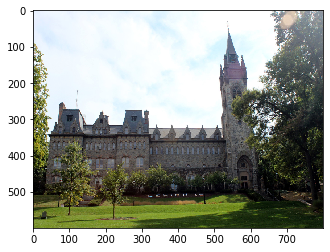

In [0]:
plt.imshow(contentImage.cpu().data)

The content image (C) shows the Lehigh most important buildings, against a sunny sky with a few clouds.

** 3.1.1 - Make generated image G match the content of image C**

#### Shallower versus deeper layers
* The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
* The deeper layers tend to detect higher-level features such as more complex textures as well as object classes. 

#### Choose a "middle" activation layer $a^{[l]}$
We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you'll get the most visually pleasing results if you choose a layer in the **middle** of the network--neither too shallow nor too deep. 
* (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

#### Forward propagate image "C"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen (all of them are store now in activationsAfterConv list). This will be an $n_C \times n_H \times n_W $ tensor.

#### Forward propagate image "G"
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

#### Content Cost Function $J_{content}(C,G)$
We will define the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to reshape these 3D volumes into a 2D matrix.
* Technically reshaping step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.



**Exercise:** Compute the "content cost" using TensorFlow. 

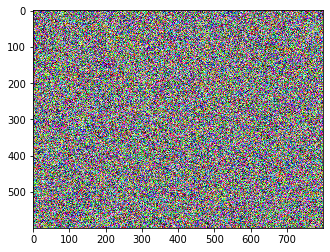

In [0]:
# we choose the G randomly which should be the image we will be learning.. it is just a random noise at begining
G = torch.rand(contentImage.shape, requires_grad=True, device="cuda")
plt.imshow(G.cpu().data)

# we can also feed this image into VGG-19 and store the activations after conv2d layers
# note: you do not need to run all layers, just up to the one in the middle!
imgInput = torch.transpose(G.unsqueeze(0),1,3)
aGs=[]
for l,isConv in layers:
  imgInput = l(imgInput)
  if isConv:
    aGs.append(imgInput)

In [0]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    J_content = 0
    return J_content
print("J_content = %f" % compute_content_cost(aCs[5], aGs[5]) )    # (e.g. if we pick activation after 5th conv. layer) 

J_content = 0.000000


#### What you should remember
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

**Exercise:** Try to use Adam optimizer to optimize "G" which will minimize compute_content_cost

Hint: maybe you will need to use 
"backward(retain_graph=True)"
explain why?

In [0]:
# create adam optimizer which will minimize compute_content_cost by changing "G"
# note after each iteration, you have to compute activations after conv2d for G
import torch.optim as optim
optimizer = optim.Adam([G],lr=0.1)

# you should run it for enought iterations to converge
# try to play with learning rate to see the effect of it
# feel free to use any other algorithm


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


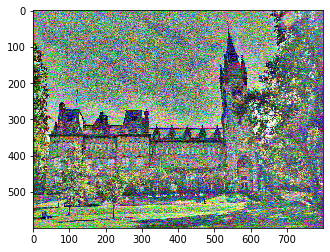

In [0]:
# you can see if the "random noise has changed to something which captures Lehigh
plt.imshow(G.cpu().data)
# are you happy with it? what would happen if you choose activations after 0th / 1st/ 2nd .... conv2d ? 


### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

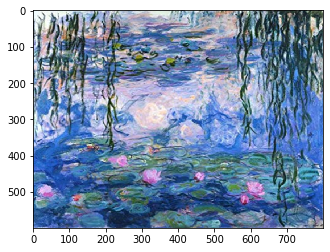

In [0]:
imshow(styleImage.cpu().data);

aSs = [] # activations for style image
# Task: store the activations after conv2d into aSs


Lets see how you can now define a "style" cost function $J_{style}(S,G)$. 

### 3.2.1 - Style matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature. 
* $G$ is used to denote the Style matrix (or Gram matrix) 
* $G$ also denotes the generated image. 
* For this assignment, we will use $G_{gram}$ to refer to the Gram matrix, and $G$ to denote the generated image.


#### Compute $G_{gram}$
In Neural Style Transfer (NST), you can compute the Style matrix by multiplying the "unrolled" (reshaped) filter matrix with its transpose:

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)i,j}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),i,i}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

**Exercise**:
* Using pytorch, implement a function that computes the Gram matrix of a matrix A. 
* The formula is: The gram matrix of A is $G_A = AA^T$. 

In [0]:
# gram_matrix
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = 0    
    return GA

### 3.2.2 - Style cost

Your goal will be to minimize the distance between the Gram matrix of the "style" image S and the gram matrix of the "generated" image G. 
* For now, we are using only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Remember, this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$


**Exercise**: Compute the style cost for a single layer. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G: 

2. Unroll (reshape) the hidden layer activations a_S and a_G into 2D matrices with size $(n_c, n_w\times n_h)$
3. Compute the Style matrix of the images S and G. (Use the function you had previously written.) 
4. Compute the Style cost 

In [0]:
# compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    J_style_layer = 0

    
    return J_style_layer

In [0]:
print("J_style_layer = %f " % compute_layer_style_cost(aSs[5], aGs[5])  )

J_style_layer = 0.000000 


### 3.2.3 Style Weights

* So far you have captured the style from only one layer. 
* We'll get better results if we "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$.
* By default, we'll give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

In [0]:
STYLE_LAYERS_WEIGHTS = [1.0/16 for i in range(16)] # weights 

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


### Exercise: compute style cost

* We've implemented a compute_style_cost(...) function. 
* It calls your `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`. 
* Please read over it to make sure you understand what it's doing. 

#### Description of `compute_style_cost`
For each layer:
* Select the activation (the output tensor) of the current layer.
* Get the style of the style image "S" from the current layer.
* Get the style of the generated image "G" from the current layer.
* Compute the "style cost" for the current layer
* Add the weighted style cost to the overall style cost (J_style)

Once you're done with the loop:  
* Return the overall style cost.

In [0]:
def compute_style_cost(aGs, aSc, STYLE_LAYERS_WEIGHTS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    aGs, aSc -- activations after conv2d for G ans S images
    STYLE_LAYERS -- A python list containing a coefficient for each cost layer
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above
    """
    
    # initialize the overall style cost
    J_style = 0

    return J_style

## What you should remember
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. 
- We get even better results by combining this representation from multiple different layers. 
- This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 



### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**Exercise**: Implement the total cost function which includes both the content cost and the style cost. 


## What you should remember
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$.
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

## 4 - Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!

To start use $\alpha = 10$ and $\beta = 40$

### Optimizer

* Use the Adam optimizer to minimize the total cost `J`.
* Play with learning rates as well

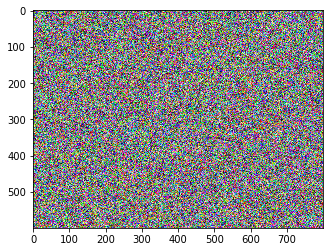

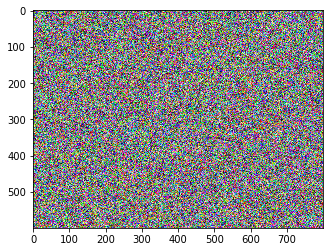

In [0]:
G = torch.rand(contentImage.shape, requires_grad=True, device="cuda")
plt.imshow(G.cpu().data)
plt.show()
optimizer = optim.Adam([G],lr=0.1)

for it in range(100):
  pass
  # set grads to 0
  # compute aGs
  # compute loss function J 
  # take optimization step


plt.imshow(G.cpu().data) # see how much the image is improved! :) 
# if it is ugly, try to play with the optimization algorithm parameters
# or optimize for longer
# or play with anything else ;)






You're done! 

We didn't want you to wait too long to see an initial result, and so had set the hyperparameters accordingly. To get the best looking results, running the optimization algorithm longer (and perhaps with a smaller learning rate) might work better. 

## 5 - Test with your own image 

Finally, you shold rerun the algorithm on your own images! 

You should include images in your report showing what you have tried. More fun - better!

You can show some interesting pictures from your country, etc...



## 6 - Conclusion

Great job on completing this assignment! You are now able to use Neural Style Transfer to generate artistic images. This is also your first time building a model in which the optimization algorithm updates the pixel values rather than the neural network's parameters. Deep learning has many different types of models and this is only one of them! 

## What you should remember
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 




### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015).  

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
